# Noise, Noise, and More Noise

In [1]:
#this code is using qiskit version 1.2.0 and qiskit_aer 0.15.1

import numpy as np
import matplotlib.pyplot as plt
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import circuit_drawer, plot_histogram
from qiskit_aer import AerSimulator
from qiskit import transpile

from qiskit_aer.noise import (
    NoiseModel,
    depolarizing_error
)

### Task 3: Adding two numbers with a quantum computer (functions)

Build a function (quantum sum) to add two numbers using the Draper adder algorithm.

You will need the Quantum Fourier Transform (QFT). 

Many libraries offer a function to use it.

For this task, you will need to build QFT from scratch.

In [2]:
def my_QFT(num_qubits:int,
            inverse:bool=False):

    """ Quantum Fourier Transform circuit

    Args:
        num_qubits: The number of qubits that QFT acts on
        inverse: The boolean flag whetehr the inverse of QFT should be applied
    
    Returns:
        QuantumCircuit

    """
    qft_qc = QuantumCircuit(num_qubits)
    
    for qubit_i in range(num_qubits):
        qft_qc.h(num_qubits-qubit_i-1) #apply Hadamard gate
        for qubit_k in range(qubit_i+1, num_qubits): #iterate over contole qubits
            l = qubit_k - qubit_i #index of the phase gate
            qft_qc.cp(np.pi/(2**l), num_qubits-qubit_k-1, num_qubits-qubit_i-1)
    
    if inverse: #return the IQFT 
        return qft_qc.inverse()
    else:
        return qft_qc

def quantum_sum(a:int,
                b:int):

    """ Quantum adder (full arithmetic additions, not modular additions)

    Args:
        a: First term
        b: Second term
        
    Returns:
        QuantumCircuit with measurements of the register that contain the sum in binary representation

    """

    #obtain binary representation of input integers
    n = max(a.bit_length(), b.bit_length()) #size of the register to store binary numbers

    #reverting strings to match qiskit convention of qubits
    a_binary = np.binary_repr(a, width=n)[::-1]
    b_binary = np.binary_repr(b, width=n)[::-1]
   
    #create registers to store term a and b
    a_reg = QuantumRegister(n+1, 'a') #register to store the first term + ancilla
    b_reg = QuantumRegister(n, 'b') #register to store the second term

    qc = QuantumCircuit(b_reg, a_reg) #construct a circuit

    #encode binary numbers into states
    for i, bit in enumerate(b_binary+a_binary): 
        if bit == '1':
            qc.x(i)
    qc.barrier()
    
    #apply QFT to state |a>
    qc.compose(my_QFT(n+1), qubits = a_reg, inplace=True)
    qc.barrier()
    
    #add |b> to obtain the sum |phi(a+b)> in register a
    #we applying in reverse order to subsytem a to avoid using swaps
    for qubit_a in reversed(range(n+1)):
        for qubit_b in range(n):
            l = qubit_a - qubit_b #angle of the phase gate
            if l>=0:
                qc.cp(np.pi/(2**l), b_reg[qubit_b], a_reg[qubit_a])
    qc.barrier()
    
    #perform inverse QFT on a register to convert the sum to intial basis
    qc.compose(my_QFT(n+1, inverse=True), qubits=a_reg, inplace=True)
    qc.barrier()

    #add classical register to measure qubits, which store the sum
    c_reg = ClassicalRegister(n+1, 'creg')
    qc.add_register(c_reg)
    qc.measure(a_reg, c_reg)

    return qc

###  Task 1 and 2: Noise Model (including basis gates)

A standard way to represent the noise in a quantum circuit is through Pauli operators ( σ𝑥, σ𝑦, σ𝑧).

Build a function with input α, β and QuantumCircuit where:
* α → Probability of having a random Pauli operator acting on the qubit after a one-qubit gate
* β → Probability of having a random Pauli operator acting on the qubit after a two-qubit gate
* QuantumCircuit → Quantum circuit where the noise will be added

The output should be the Quantum Circuit with Noise

Since qiskit is leveraged for this task, we define a fucntion that will construct a custom noise model. This noise model will later be used for creating a noisy simulator to execute transpiled circuits. Adding Pauili operators manually to a circuit is inefficient, since it requires creating a different circuit for each shot. Noisy simulator will take care of modelling the effect of noise. 

Having a random Pauli operator to one-qubit or two-qubit corresponds to a depolorazing channel, when the same probability corresponds to σ𝑥, σ𝑦, σ𝑧 . This is why depolarizing_error was used in the custom_noise_model function. 



In [3]:
def custom_noise_model(alpha:float,
                       beta:float,
                       basis_gates:list):

    """ Noise model

    Args:
        alpha: Probability of having a random Pauli operator acting on the qubit after a one-qubit gate
        beta: Probability of having a random Pauli operator acting on the qubit after a two-qubit gate
        basis_gates: A list of gates native to hardware
    
    Returns:
        Custom noise model that was created based on the provided errors

    """
    
    #create a noise model
    custom_noise_model = NoiseModel(basis_gates = basis_gates) #create an empty noise model with the basis gates

    single_qubit_error = depolarizing_error(alpha, 1) # add single-qubit gate Pauli errors with the same probability (corresponds to the DP channel)
    custom_noise_model.add_all_qubit_quantum_error(single_qubit_error, ['id', 'rz', 'sx', 'x'])

    two_qubit_error = depolarizing_error(beta, 2) # add two-qubit gate Pauli errors with the same probability (corresponds to the DP channel)
    custom_noise_model.add_all_qubit_quantum_error(two_qubit_error, ['cx'])


    return custom_noise_model

### Task 4: Effects of noise on quantum addition

In [4]:
#Initialize the problem 
basis_gate_set = ['cx', 'id', 'rz', 'sx', 'x']

#for quantum adder
first_number = 3
second_number = 1

#for the noise model
alpha = 0.005 #error of a single qubit gates
beta = 0.05 #error of a two qubit gates
noise_model = custom_noise_model(alpha, beta, basis_gate_set)

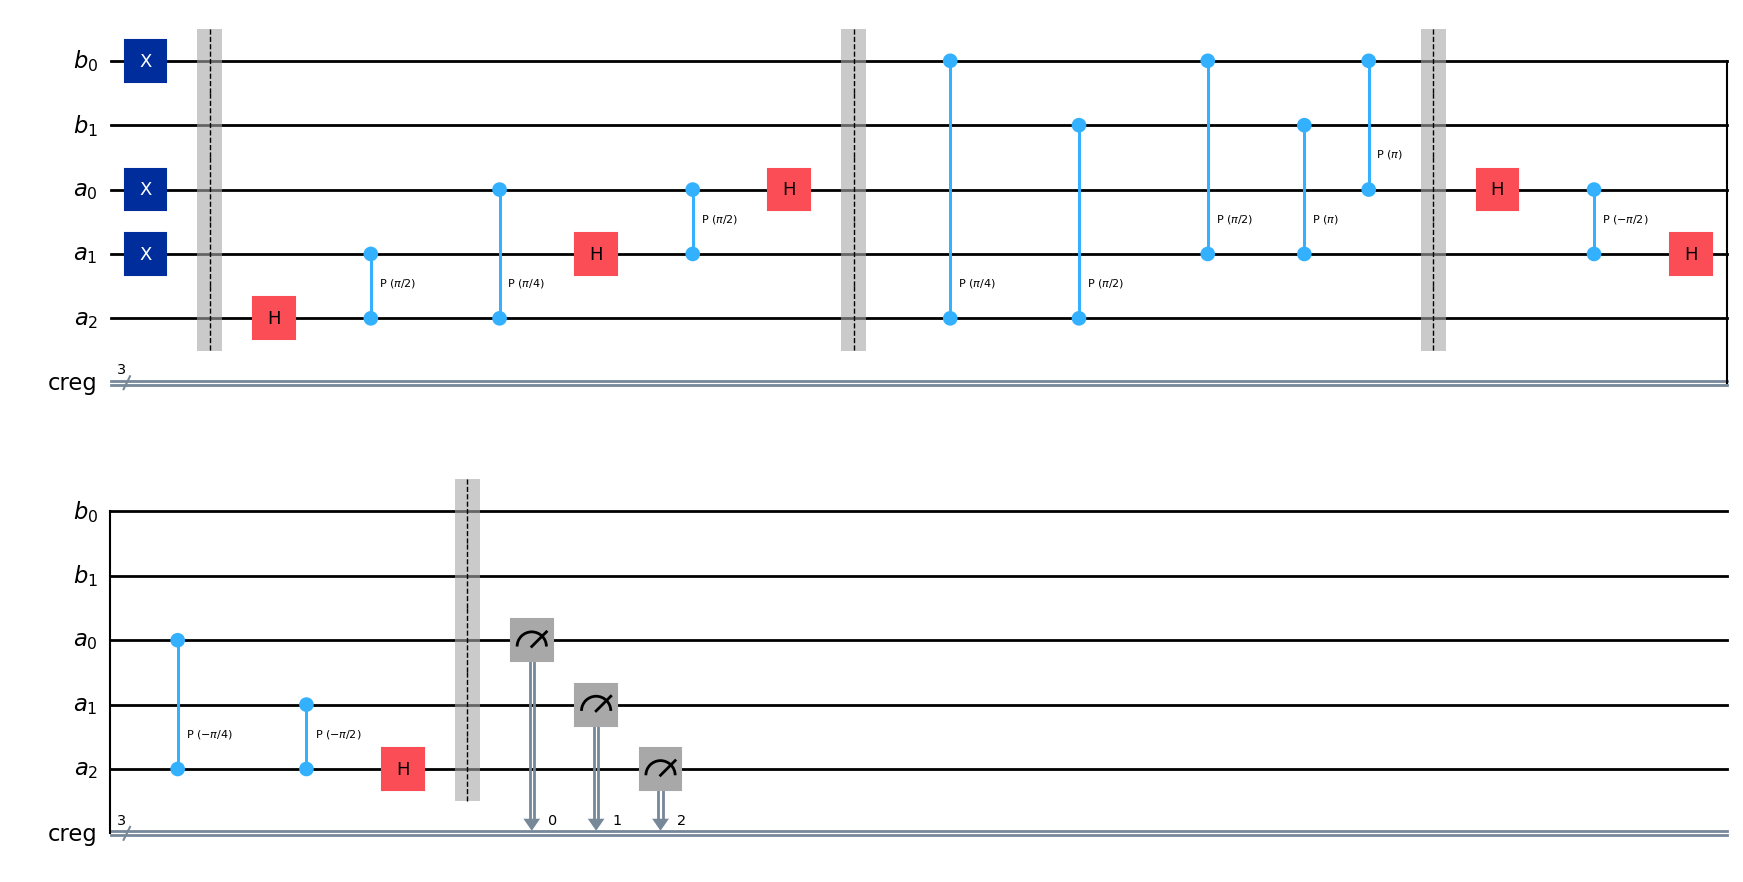

In [5]:
#obtain circuit that sums up two numbers
qc_sum = quantum_sum(first_number, second_number)
qc_sum.draw('mpl') 

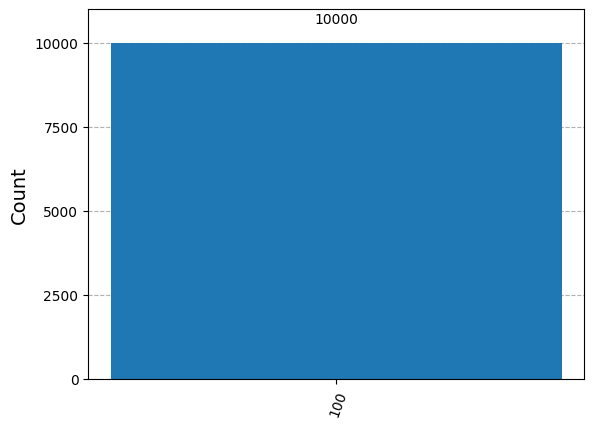

In [6]:
#run ideal simulation
shots=1e+4
sim_ideal = AerSimulator(shots=shots) #initialize an ideal simulator
result_ideal = sim_ideal.run(qc_sum).result() 
plot_histogram(result_ideal.get_counts())

In [7]:
#retrieve an answer from an ideal simulator
print("Ideal simulator results")
for keys, vals in result_ideal.get_counts().items():
    print(f"Quantum adder result for summing {first_number} and {second_number} is {int(keys, 2)} with probability {vals/shots}")

Ideal simulator results
Quantum adder result for summing 3 and 1 is 4 with probability 1.0


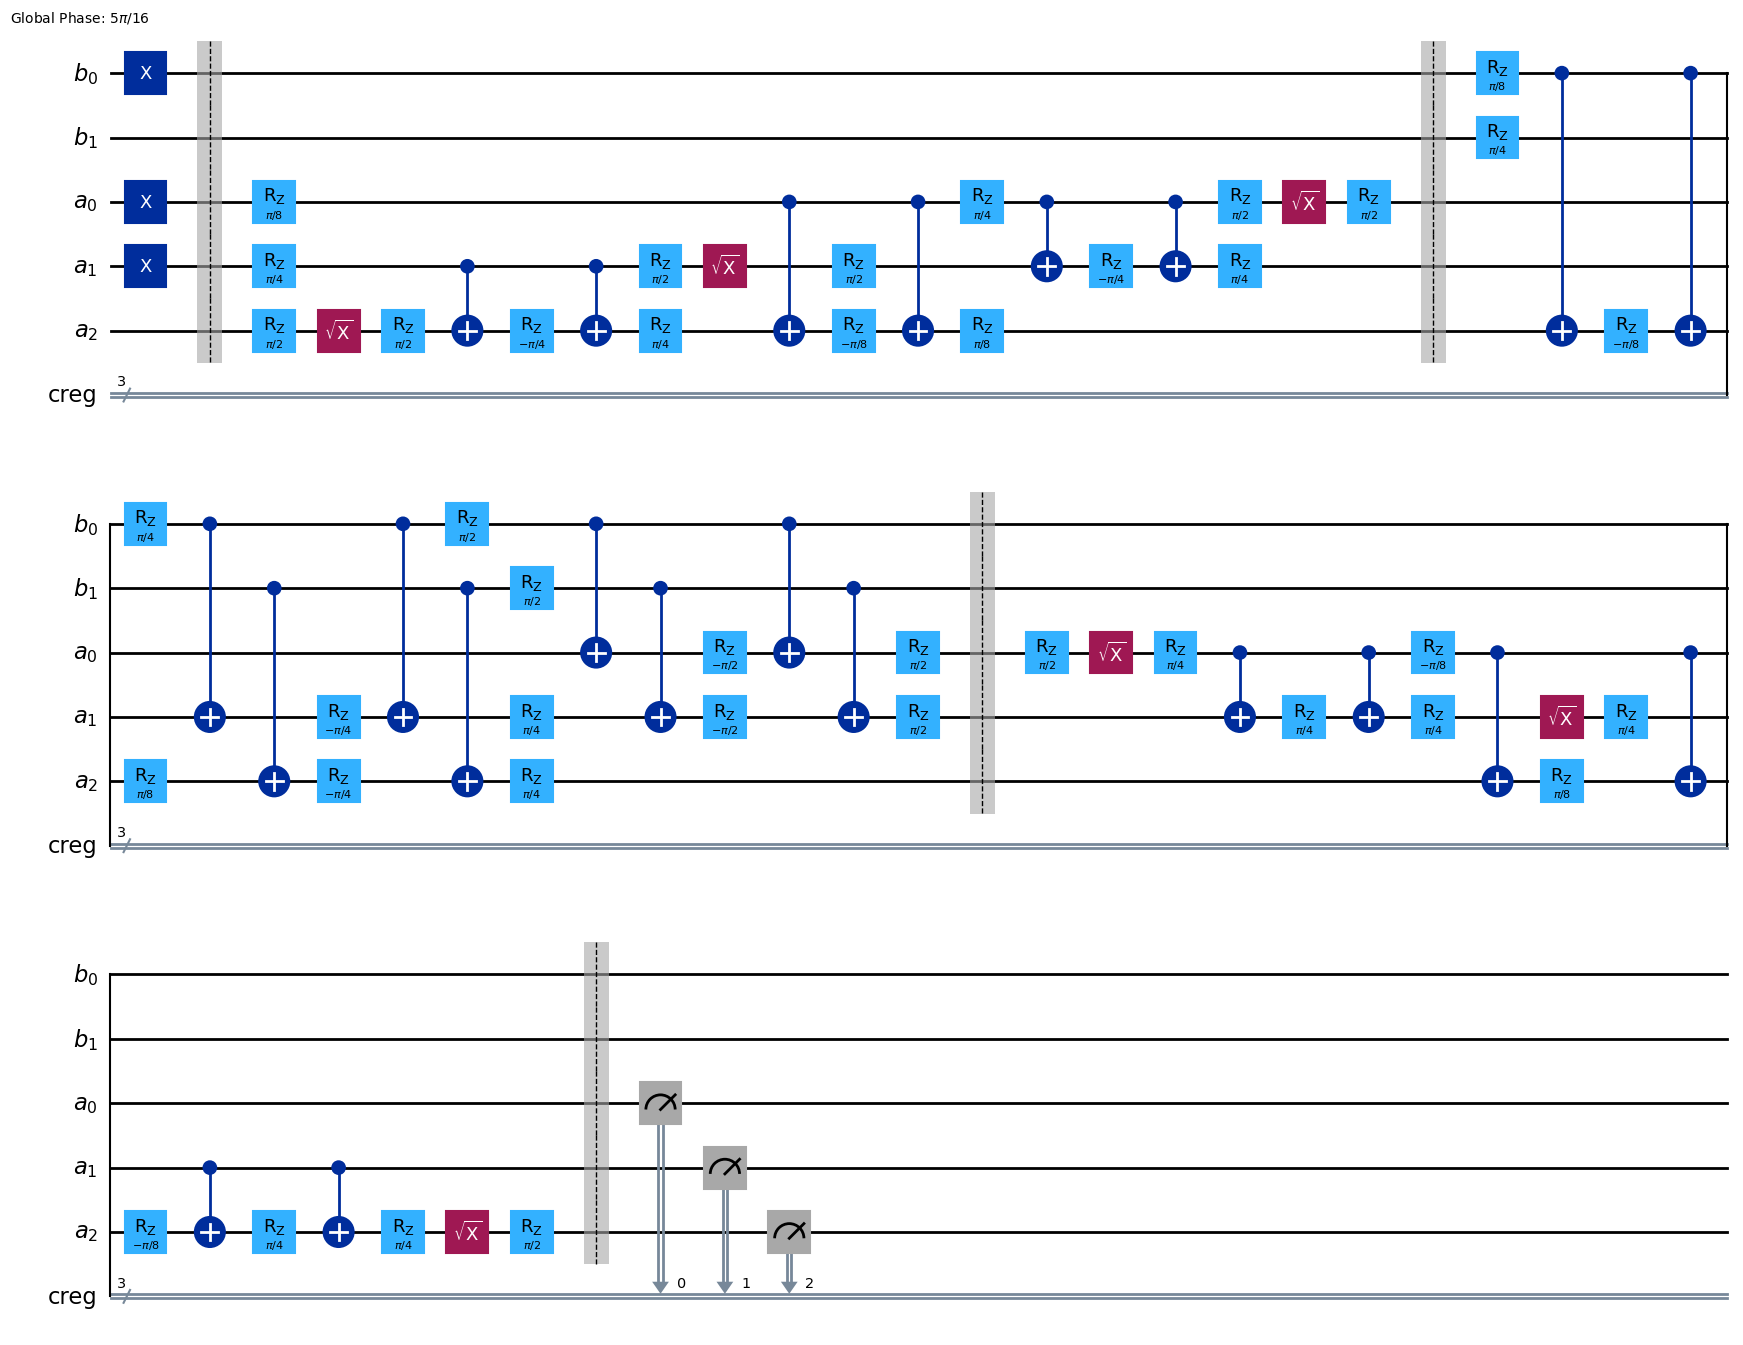

In [8]:
#transpile the circuit to a noisy backend basis gates
qc_sum_t = transpile(qc_sum, basis_gates=basis_gate_set)
qc_sum_t.draw('mpl')

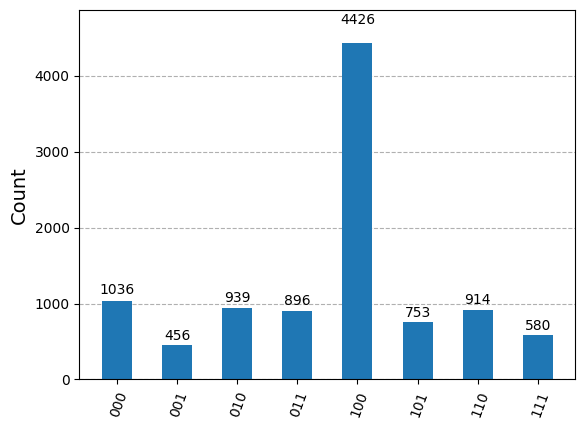

In [9]:
# Run and get counts on noisy simulator
shots=1e+4
sim_noise = AerSimulator(noise_model=noise_model, shots=shots) #initialize a noisy simulator
result_noise = sim_noise.run(qc_sum_t).result()
plot_histogram(result_noise.get_counts())

In [10]:
#retrieve an answer from a noisy simulator
print("Noisy simulator results")
for keys, vals in result_noise.get_counts().items():
    print(f"Quantum adder result for summing {first_number} and {second_number} is {int(keys, 2)} with probability {vals/shots}")

Noisy simulator results
Quantum adder result for summing 3 and 1 is 5 with probability 0.0753
Quantum adder result for summing 3 and 1 is 1 with probability 0.0456
Quantum adder result for summing 3 and 1 is 6 with probability 0.0914
Quantum adder result for summing 3 and 1 is 4 with probability 0.4426
Quantum adder result for summing 3 and 1 is 2 with probability 0.0939
Quantum adder result for summing 3 and 1 is 0 with probability 0.1036
Quantum adder result for summing 3 and 1 is 3 with probability 0.0896
Quantum adder result for summing 3 and 1 is 7 with probability 0.058


### Analysis of the results

In [11]:
#some general plotting settings
fontsize = 16
legendfontsize = 14
linethickness = 2
axislinethickness = 2
colors = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
plt.rcParams['font.size'] = fontsize

In [12]:
#correct solution
solution_btstr =  np.binary_repr(first_number + second_number)
solution_btstr

'100'

* How does the noise affect the results?


In [13]:
#build noise models for various alpha and beta
#we will log the probability of the correct solution
#this will allow us to see how the probability is changing with the increase of noise
qc_sum_t
magnitude_orders = 10.**(np.arange(-3, 0))
values = np.arange(1,10,1)
alpha_range = np.outer(magnitude_orders[:-1], values).flatten() #define values for single-qubit errors
beta_range = np.outer(magnitude_orders[1:], values).flatten() #define values for two-qubit errors

solution_prob_matrix = np.zeros((len(beta_range), len(alpha_range))) * np.nan #put all the results in the matrix

for idb, beta in enumerate(beta_range):
    for ida, alpha in enumerate(alpha_range):
        noise_model = custom_noise_model(alpha, beta, basis_gate_set)
        sim_noise = AerSimulator(noise_model=noise_model, shots=shots)
        solution_prob = sim_noise.run(qc_sum_t).result().get_counts()[solution_btstr]/shots #check the probbility of the solution
        solution_prob_matrix[idb, ida] = solution_prob

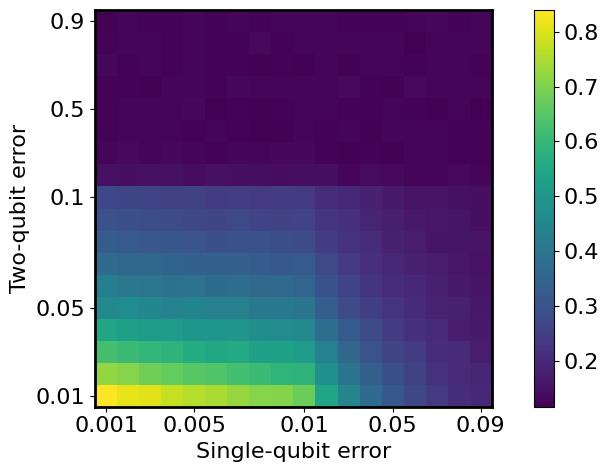

In [14]:
#plot the probability of the correct solution vs alpha, beta
fig, ax = plt.subplots(1,1, figsize=(9,5), tight_layout=True, sharex='col')

im = ax.imshow(solution_prob_matrix, origin='lower')
ax.set_ylabel("Two-qubit error")
ax.set_xlabel("Single-qubit error")
tick_positions = [0, 4, 9, 13, 17]
ax.set_yticks(tick_positions)
ax.set_yticklabels(beta_range[tick_positions])
ax.set_xticks(tick_positions)
ax.set_xticklabels(alpha_range[tick_positions])

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(axislinethickness)

plt.subplots_adjust(wspace=0, hspace=0)
plt.colorbar(im)

We observe the decay of the correct solution probability with the increase in single-qubit and two-qubit gate erors. 

* How does the number of gates used affect the results?

In [15]:
#let's vary the number of gates used in the circuit by obtaining sum for different number
number_pairs = [(3, 1), (5, 3), (10, 6), (28, 4)]

#obtain circuits that sums numbers
circuits_list = []
for pair in number_pairs:
    circuits_list.append(quantum_sum(pair[0], pair[1]))


In [16]:
#check the answers on ideal simulator
for idc, circuit in enumerate(circuits_list):
    result_ideal = sim_ideal.run(circuit).result().get_counts()
    for keys, vals in result_ideal.items():
        print(f"Quantum adder result for summing {number_pairs[idc][0]} and {number_pairs[idc][1]} is {int(keys, 2)} with probability {vals/shots}")

Quantum adder result for summing 3 and 1 is 4 with probability 1.0
Quantum adder result for summing 5 and 3 is 8 with probability 1.0
Quantum adder result for summing 10 and 6 is 16 with probability 1.0
Quantum adder result for summing 28 and 4 is 32 with probability 1.0


In [17]:
#transpile the circuits
circuits_t_list = []
for circuit in circuits_list:
    circuit_t = transpile(circuit, basis_gates=basis_gate_set)
    circuits_t_list.append(circuit_t)

In [18]:
#set the error values for the noise model
alpha = 0.005
beta = 0.05
shots = 1e4

noise_model = custom_noise_model(alpha, beta, basis_gate_set)

#check the answers on noisy simulator
sim_noise = AerSimulator(noise_model=noise_model, shots=shots) #initialize a noisy simulator
prob_solution_list = []

for idc, circuit in enumerate(circuits_t_list):
    solution_btstr =  np.binary_repr(number_pairs[idc][0] + number_pairs[idc][1]) 
    result_noise = sim_noise.run(circuit).result().get_counts()
    solution_prob = result_noise[solution_btstr]/shots #check the probbility of the solution
    prob_solution_list.append(solution_prob)
    print(f"Quantum adder result for summing {number_pairs[idc][0]} and {number_pairs[idc][1]} is {int(solution_btstr, 2)} with probability {solution_prob}")


Quantum adder result for summing 3 and 1 is 4 with probability 0.4428
Quantum adder result for summing 5 and 3 is 8 with probability 0.227
Quantum adder result for summing 10 and 6 is 16 with probability 0.0979
Quantum adder result for summing 28 and 4 is 32 with probability 0.0414


In [19]:
gates = ['cx', 'rz', 'x', 'sx', 'id']
gate_count_list = []
for circuit in circuits_t_list:
    gates_dict = circuit.count_ops()
    gate_count_list.append(sum(gates_dict[gate] for gate in gates if gate in gates_dict))

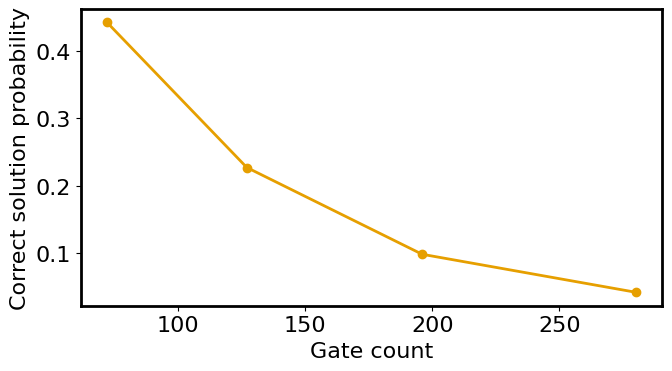

In [20]:
#plot the correct solution probability vs gate count
fig, ax = plt.subplots(1,1, figsize=(7,4), tight_layout=True, sharex='col')

ax.plot(gate_count_list, prob_solution_list, linewidth=linethickness, marker="o", color=colors[0])
ax.set_ylabel("Correct solution probability")
ax.set_xlabel("Gate count")

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(axislinethickness)

plt.subplots_adjust(wspace=0, hspace=0)


As expected, the probability of the correct solution is decreasing with the number of gates.

* Is there a way to decrease the effect of noise?


To decrease the effect of noise, one can apply error mitigation techniques such as zero-noise exptrapolation or probabilistic error concelation for a given noise model. Here, we are not taking into account read-out errors, since our noise model doesn't contain those errors. To implement this in qiskit one would need to use qiskit runtime primitives. Unfortunantly, it looks like the current version of qiskit aer simulator is not compatible with error mitigation algorithms. 